# Simple housing model

Your task is to implement a simple model to predict home prices for a small real estate transactions dataset.

Instructions:
Predict the close price as of list date given the other attributes.
Build separate models with and without ListPrice.
Feel free to join the dataset to any other data sources, so long as they are not leaky.

Questions:
How would you improve your model?

## Outline
<a href='#section1'>1. Load Libraries and Data</a>  
<a href='#section2'>2. Preprocessing - Data Cleaning</a>  
<a href='#section3'>3. Preprocessing - Feature Engineering</a>  
<a href='#section4'>4. Preprocessing - Convert Categorical to Dummy Vectors</a>  
<a href='#section5'>5. Analysis - Data Set Creation</a>  
<a href='#section6'>6. Analysis - Recursive Feature Elimination</a>  
<a href='#section7'>7. Regression Model - Random Forest</a>  
<a href='#section8'>8. Regression Performance</a>  
<a href='#section9'>9. What is Next?</a>

<a id='section1'></a>
## Load Libraries and Data

In [2]:
%matplotlib inline

import os
import time
import math
import re

import numpy as np
import pandas as pd
import datetime as dt
import statistics as stat

from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


#Classification Specific:
#from sklearn.metrics import classification_report
#from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
#                             f1_score)
#Regression Specific:
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [93]:
## Load Data Set
df = pd.read_csv('data_sci_snippet.csv')
df.head(1)

ListingId  LivingArea  NumBedrooms  NumBaths     Pool  ExteriorStories  \
0    5077399        3054            4       2.5  Private                1   

     ListDate  ListPrice     GeoLat      GeoLon  \
0  2014-03-04     675000  33.593239 -111.961056   

                                       PublicRemarks CloseDate  ClosePrice  \
0  This property OUTSTANDING offers outdoor livin...       NaN         NaN   

  ListingStatus              DwellingType  
0     Cancelled  Single Family - Detached

<a id='section2'></a>
## Preprocessing

### Data Cleaning

In [94]:
## Convert Dates: str to Datetime
df['ListDate'] = pd.to_datetime(df['ListDate'])
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
## Convert Dates: datetime to ordinals
df['CloseDateInt'] = df['CloseDate'].apply(lambda x: x.toordinal())
df['ListDateInt'] = df['ListDate'].apply(lambda x: x.toordinal())

In [95]:
## Remove or Impute Missing Data
## If count(NaN) << 1% of Data: drop row
## Else impute with median values or Multiple-Imputations
#print('Number of rows containing data:\n', df.count(), sep='')
#print('Number of rows with missing data:\n', df.isnull().sum(), sep='')
print('Percent missing data:\n', sep='')
print(df.isnull().sum()/df.count().max()*100)

Percent missing data:

ListingId           0.000000
LivingArea          0.365014
NumBedrooms         0.000000
NumBaths            0.000000
Pool                0.000000
ExteriorStories     0.000000
ListDate            0.000000
ListPrice           0.000000
GeoLat              0.172902
GeoLon              0.172902
PublicRemarks       0.995494
CloseDate          33.748996
ClosePrice         33.748996
ListingStatus       0.000000
DwellingType        0.000000
CloseDateInt        0.000000
ListDateInt         0.000000
dtype: float64


In [96]:
## Drop or Impute: Living Area:
## If None, replace with median value, ideally from Zip or town 
# Drop
#df = df[df.LivingArea.notnull()]
#-OR-
# Impute
df['LivingArea'].fillna(df['LivingArea'].mean(), inplace=True)  #.mean / .median / knn(which isn't implemented)
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code gorouping

# Test
#df[df['ListingId'] == 5140687]  # Confirm NaN replaced with median
#df.isnull().sum()

In [97]:
## Drop or Impute: GeoLat/GeoLon
## This data might be in the 'PublicRemark'
# Drop
#df = df[df.GeoLat.notnull()]
#df = df[df.GeoLon.notnull()]
#-OR-
# Impute
df['GeoLat'].fillna(df['GeoLat'].mean(), inplace=True)  #.mean or .median
df['GeoLon'].fillna(df['GeoLon'].mean(), inplace=True)  #.mean or .median
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code grouping
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code grouping

# Test
#df.isnull().sum()

In [111]:
## PublicRemarks: Replace Null with placeholder ' '
df['PublicRemarks'].fillna(' ', inplace=True)

## Lower Case PublicRemarks (00m:07s)
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : re.sub(r'[\b\(\)\\\"\'\/\[\]\s+\,\.:\?!;#~*=+-_]', ' ', x))
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : re.sub( '\s+', ' ', x).strip() )  # remove white space
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : x.lower())

# Test
#df[df.PublicRemarks.isnull()]  # If it works the output has zero rows.

Empty DataFrame
Columns: [ListingId, LivingArea, NumBedrooms, NumBaths, Pool, ExteriorStories, ListDate, ListPrice, GeoLat, GeoLon, PublicRemarks, CloseDate, ClosePrice, ListingStatus, DwellingType, CloseDateInt, ListDateInt, TimeToClose, PostalCode]
Index: []

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


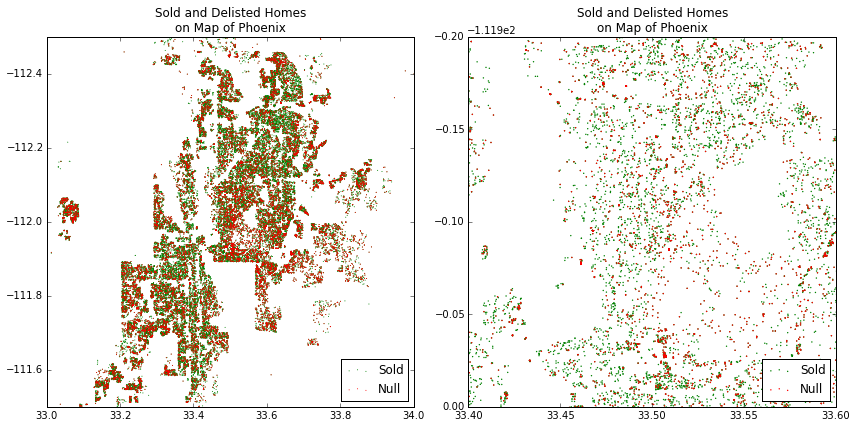

In [99]:
## Test ClosePrice: Verify unbiased null data

ClosePriceNull = df[df.ClosePrice.isnull()]
#ClosePriceNull.head(1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlim(33,34)
plt.ylim(-111.5,-112.5)
plt.scatter(df['GeoLat'], df['GeoLon'], s=1, c='g', edgecolor='none', label='Sold')
plt.scatter(ClosePriceNull['GeoLat'], ClosePriceNull['GeoLon'], s=1, c='r', edgecolor='none', label='Null')
plt.title('Sold and Delisted Homes\non Map of Phoenix')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.xlim(33.4,33.6)
plt.ylim(-111.9,-112.1)
plt.scatter(df['GeoLat'], df['GeoLon'], s=2, c='g', edgecolor='none', label='Sold')
plt.scatter(ClosePriceNull['GeoLat'], ClosePriceNull['GeoLon'], s=2, c='r', edgecolor='none', label='Null')
plt.title('Sold and Delisted Homes\non Map of Phoenix')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [101]:
## ClosePrice:  <--Last pre-processing step!
## Exclude Null ClosePrice Data, because it doesn't inform the ML algo
df = df[df.ClosePrice.notnull()].reset_index(drop=True)
# Removes are rows with no ClosePrice and resets index

In [102]:
## Confirm Dataset Cleaned!
print(df.shape)
df.isnull().sum()

(37934, 17)


ListingId          0
LivingArea         0
NumBedrooms        0
NumBaths           0
Pool               0
ExteriorStories    0
ListDate           0
ListPrice          0
GeoLat             0
GeoLon             0
PublicRemarks      0
CloseDate          0
ClosePrice         0
ListingStatus      0
DwellingType       0
CloseDateInt       0
ListDateInt        0
dtype: int64

<a id='section3'></a>
### Feature Engineering

In [103]:
## Add TimeToClose  # Hypothesis: As time to close -> increases, ClosePrice decreases
df['TimeToClose'] = df['CloseDateInt'] - df['ListDateInt']

In [104]:
## Generate Postal Code
## Input: (Lat/Long/(zipcode/geoJSON)) -> output: Zip Code
#import sys  # Used to import method from file
#sys.path.insert(1,'/users/wschram/Documents/Github/Regression_Challenge')

import json
import geojson

## Load Data Set
zips = pd.read_csv('zips.csv')
zips['polygon'] = zips['geojson'].apply(lambda x : list(geojson.utils.coords(json.loads(x))))

# Force Lat and Lon to float
zips['Lat'] = np.nan  #.astype(float)
zips['Lon'] = np.nan  #.astype(float)
# Use mean of path as Centroid proxy
zips['Lat'] = zips['polygon'].apply(lambda x : np.mean([pair[1] for pair in x ])) #<-doesn't work!
zips['Lon'] = zips['polygon'].apply(lambda x : np.mean([pair[0] for pair in x ]))

## Method: Ray Casting
def point_in_poly(x, y, poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
        
    return inside


## Convert Lat/Lon, via a GeoJSON polygon, to Postal Code
def coord_in_zip(Lat, Lon, zips):
    # sort zips by Lat, and in the future Lon
    df2 = zips.ix[((zips.Lat-Lat)+(zips.Lon-Lon)).abs().argsort()].reset_index(drop=True) # [:20] , after argsort()
    #df2 = zips.ix[(zips.Lat-Lat).abs().argsort()[:8]].reset_index(drop=True)  # OLD: 1-axis version
    # Test Lat/Lon against zipcode geoJSON, return Postal Code
    for row in range(len(df2)):
        if point_in_poly(Lon, Lat, df2['polygon'].loc[row]) == True:
            return df2['postal_code'].loc[row]
        else:
            pass

In [106]:
## Postal Code Array (00h43m47s)
start_time = time.time()

df['PostalCode'] = np.nan
for i in range(0, len(df)):
    if pd.isnull(df['PostalCode'][i]) == True:
        df.loc[i,'PostalCode'] = coord_in_zip(df['GeoLat'][i], df['GeoLon'][i], zips)  # Replaced: df['PostalCode'][i]
    else: pass

stop_time = time.time()
print("Computation time: %.2fs" % (stop_time - start_time))
os.system('say "Computation complete!"');


## Debug
#print(df['GeoLat'][4],df['GeoLon'][4])
#print( df.loc[12830:12860,'PostalCode'] )
#row = 508
#print(df['GeoLat'][row],df['GeoLon'][row])
#print( pd.isnull( df['PostalCode'][1] ) )

Computation time: 414.01s


In [107]:
## Summary
count = df['PostalCode'].isnull().sum()
print('Number of rows without a Postal Code\t:', count)  
print('Number of rows total\t\t\t:', len(df))

Number of rows without a Postal Code	: 883
Number of rows total			: 37934


In [108]:
## Add PostalCode with Web Queries
##    b/c long / lat doesn't define neighborhoods or school dist.
##    A dummy vector of the zip is better!
### --> DANGER: this code takes a long time to run! <--

from geopy.geocoders import Nominatim

geolocator = Nominatim()

for n in range(0,len(df)):   # len(df)  #0,len(df2) #100=35s  500=2m:41s
    try:
        if math.isnan(df.loc[n,'PostalCode']) == True:
            df.loc[n,'PostalCode'] = int(geolocator.reverse('{lat}, {long}'.format(lat=str(df.loc[n,'GeoLat']), long=str(df.loc[n,'GeoLon']))).raw['address']['postcode'])
        else: pass # Row already solved!
    except: 
        print(n, df.loc[n,'GeoLat'], df.loc[n,'GeoLon'], df.loc[n,'PostalCode'])


#import os; 
os.system('say "Postal code web queries complete!"');
#os.system('say beep');

## Debug Tools
#type( df.loc[37932,'PostalCode'] )
#df.loc[2511,]
#df.loc[11:500,['ZipCode']]
#df.loc[1600:1610,['GeoLat','GeoLon','ZipCode']]
#df['ZipCode'].value_counts()
#df['GeoLat'].value_counts()

241 34.635942 -111.129106 nan
364 33.321139 -112.960082 nan
443 32.81109 -111.637475 nan
1706 33.425869 -112.802593 nan
1963 32.8097 -111.639291 nan
4249 34.35871 -111.529095 nan
4699 35.101757 -111.720889 nan
4783 34.375422 -110.481827 nan
5070 35.103135 -111.714605 nan
5071 35.103147 -111.714564 nan
5168 34.39453 -110.539842 nan
5434 32.809247 -111.634629 nan
5832 32.812633 -111.63054 nan
6023 35.102364 -111.710041 nan
8173 32.811825 -111.643384 nan
9901 34.64004 -111.127392 nan
9905 32.811745 -111.64251 nan
10038 34.832997 -112.883001 nan
10473 34.083258 -109.958573 nan
11111 34.375422 -110.481827 nan
13206 34.956703 -111.488228 nan
13471 33.292445 -112.796889 nan
13624 34.083258 -109.958573 nan
13843 34.734138 -111.156226 nan
14813 32.784322 -111.523102 nan
15631 34.650771 -111.11126 nan
16438 35.23434 -111.80893 nan
16860 34.385852 -110.53035 nan
17421 35.234489 -112.221774 nan
20779 33.368217 -112.765445 nan
21249 34.375603 -110.481827 nan
21268 34.375603 -110.481827 nan
21474 35

0

In [109]:
## Summary
count = df['PostalCode'].isnull().sum()
print('Number of rows without a Postal Code\t:', count)  
print('Number of rows total\t\t\t:', len(df))

Number of rows without a Postal Code	: 61
Number of rows total			: 37934


In [112]:
## Save to .csv / .json / .txt
#df.to_json('FeatureEngineering.json') 
df.to_csv('FeatureEngineering.csv')

In [110]:
## Read from .csv / .json / .txt
df = pd.read_csv('FeatureEngineering.csv')

#print( df.columns.tolist() )
df = df.drop(df.columns[0],axis=1)  #'Unnamed: 0',axis=1
df.head(1)

ListingId  LivingArea  NumBedrooms  NumBaths     Pool  ExteriorStories  \
0    5077408        2230            4         2  Private                1   

     ListDate  ListPrice     GeoLat      GeoLon  \
0  2014-03-01     475000  33.650984 -111.963151   

                                       PublicRemarks   CloseDate  ClosePrice  \
0  ery special home in popular rabian iews feels ...  2014-06-24      460000   

  ListingStatus              DwellingType  CloseDateInt  ListDateInt  \
0        Closed  Single Family - Detached        735408       735293   

   TimeToClose  PostalCode  
0          115       85254

<a id='section4'></a>  
### Preprocessing - Convert Categorical to Dummy Vectors
Here we address what information is obtained from postal code, pool type, and Dwelling type.  

In [68]:
## Convert Categorical vectors to dummy (1-hot encoded) binary vectors 
### --> Proven less effective than a 0-n encoding based on utility
###        or avg. valuation.

#def gen_dummies(dfColumn,columnName):
#    data = pd.DataFrame({columnName: dfColumn})
#    res = pd.get_dummies(data)
#    return res

## Generate Dummy Vectors
#poolDummies = gen_dummies(df['Pool'], 'Pool')  #list(df.columns.values)[4]
#dwellingTypeDummies = gen_dummies(df['DwellingType'], 'DwellingType')  #list(df.columns.values)[14]

## Concatenate with df
#df = pd.concat([df, poolDummies], axis=1, join_axes=[df.index])
#df = pd.concat([df, dwellingTypeDummies], axis=1, join_axes=[df.index])
#df.head(3)

In [113]:
## Convert Categorical Data to a 'hot-encoding'
# Note that the magnitude that will be assessed is based on the analyst's 
# belief in the relative utility of the option on ClosePrice.
# Effectively this turns the features from categorical to ordinal.
# Ex. X[:, 0] = LabelEncoder().fit_transform(X[:,0])

## First 'Pool' Data Set (0-3 Hot-encoding)
lePool = preprocessing.LabelEncoder()
#lePool.fit(df['Pool'])
lePool.classes_ = ['None', 
                   'Community',
                   'Private', 
                   'Both Private & Community'] # Question this assumption!
#list(lePool.classes_)
df['PoolOrd'] = np.empty(len(df), dtype=int)
df['PoolOrd'] = lePool.transform(df['Pool'])

In [114]:
## Second DwellingType (0-7 Hot-encoding)
# Rank was determined by assessing the mean ClosePrice of the
# respective DwellingType.
leDT = preprocessing.LabelEncoder()
#leDT.fit(df['DwellingType'])
leDT.classes_ = ['Modular/Pre-Fab',
                 'Mfg/Mobile Housing',
                 'Gemini/Twin Home',
                 'Apartment Style/Flat',
                 'Loft Style',
                 'Townhouse',
                 'Patio Home',
                 'Single Family - Detached']
#list(leDT.classes_)
df['DwellingTypeOrd'] = np.empty(len(df), dtype=int)
df['DwellingTypeOrd'] = leDT.transform(df['DwellingType'])

In [115]:
## Third Postal Code to Dummy (1-hot encoded) Binary Vectors
### --> Proven less effective than a 0-n encoding based on utility
###        or avg. valuation. But we'll start here.

## Reformat PostalCode to String
df['PostalCode'] = df['PostalCode'].map('{:.0f}'.format)
df['PostalCode'] = df['PostalCode'].astype('str') #.astype(int)
## Replace nan with -1
df['PostalCode'] = df['PostalCode'].replace({'nan': -1})  

# Generate Dummy Vectors
postalCodeDummies = pd.get_dummies(df['PostalCode'], prefix='Zip')  #list(df.columns.values)[20]
#print(postalCodeDummies)  

## Concatenate with df
df = pd.concat([df, postalCodeDummies], axis=1, join_axes=[df.index])
df.head(3)

ListingId  LivingArea  NumBedrooms  NumBaths     Pool  ExteriorStories  \
0    5077408        2230            4       2.0  Private                1   
1    5077486        1601            3       2.0  Private                1   
2    5077487        2440            4       2.5     None                2   

     ListDate  ListPrice     GeoLat      GeoLon    ...     Zip_86343  \
0  2014-03-01     475000  33.650984 -111.963151    ...             0   
1  2014-03-01     279900  33.692122 -112.038019    ...             0   
2  2014-03-01     229900  33.647270 -112.251490    ...             0   

  Zip_86351  Zip_86401 Zip_86403 Zip_86409  Zip_86411  Zip_86431  Zip_86432  \
0         0          0         0         0          0          0          0   
1         0          0         0         0          0          0          0   
2         0          0         0         0          0          0          0   

  Zip_86440  Zip_86601  
0         0          0  
1         0          0  
2         0          0  

[3 rows x 239 columns]

In [116]:
## Create PublicRemarks n-gram vectors
## http://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['PublicRemarks']

## Write a custom tokenizer and move df['PublicRemarks']
## formatting to this section!

# Noun Phrases in order of importance:
vocab = ['patio', 'fireplace', 'fans',
         'covered patio', 'car garage', 'bedroom bath',
         'breakfast bar', 'spa',
         'vaulted ceiling', 'ceiling fans', 
         'walk in closet', 'move in ready', 
         'stainless steel', 'washer dryer',
         'steel appliances', 'stainless steel appliances',
# Untested:
         'air conditioning',
         'hot tub',
         'granite counter', 'hardwood', 'hardwood floors',
         'fruit trees', 'trees',]

## Bad indicators: 'HOA', 'garage', 'air condition',
##                 'fixer upper', 'tree', 'BBQ Grill', 
##                 'fire pit', 'BBQ', 'hardwood floor',
##                 'AC', 'hottub', 'new water heater',

vect = CountVectorizer(ngram_range=(1,4),  # (1,1) or (1,2)
                             lowercase=True,  # Convert to lowercase
                             token_pattern=r'\b\w+\b', # r'\b\[0-9]+|w+\b'
                             vocabulary = vocab,  # List of strings
                             max_features = 250,
                             min_df=2,  # at least n letters in gram
                            )

SparseMatrix = vect.fit_transform(corpus).toarray()
VectSparseMatrix = pd.DataFrame((vect.fit_transform(corpus).toarray()), 
                                columns=[vect.get_feature_names()])
# print(VectSparseMatrix)

#  TF-IDF  # This doesn't work try useing the TF-IDF Vectorizer!!!
#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#VectSparseMatrix = TfidfTransformer(VectSparseMatrix)

#Experiement with .to_sparse() to remove zeros from df.
#PandasSparseMatrix  # Returns size of sparse matrix

In [ ]:
## Debug: List PublicRemarks Attributes 
#df['PublicRemarks'][5]
#vectorizer.get_feature_names()
#PandasSparseMatrix.describe()
#VectSparseMatrix.shape
#PandasSparseMatrix.isnull().sum()

In [117]:
## Concatenate PublicRemark Attributes to dataframe
data = pd.concat([df, VectSparseMatrix], axis=1, join_axes=[df.index])
data = data.fillna(0)  # Catches NAs in dataset, found by RandomForest

## Test concat
print(data.shape)
#df.isnull().sum()

(37934, 265)


<a id='section5'></a>
## Analysis - Data Set Creation

In [118]:
## Generate Training and Test Data Set (X , y)
# Training Variables
X = data.drop(['ListDate',
             'PublicRemarks',  #May add n-grams to create booleans from this feature
             'CloseDate',
             'ClosePrice',
             'ListingStatus',
             'Pool',
             'DwellingType',
             'PostalCode'], axis=1)
headers = X.dtypes.index

X.shape
#X.describe()

(37934, 257)

In [119]:
# Prediction Variable
y = df['ClosePrice']
y.shape

(37934,)

In [84]:
## Divide set into 66/33 (Train/Validation)/Test sets
## Use when comparing algorithms.
## In k-fold validation train and test data will interchange
#X, y, X_test, y_test = cross_validation.train_test_split(X, y, train_size=0.66, test_size=0.33, random_state=0)

In [85]:
## Divide set into 60/20/20 Train/Validation/Test sets 
## Use when comparing algorithms.
#X_train, X_intermediate, y_train, y_intermediate = cross_validation.train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=0)
#X_validation, y_validation, X_test, y_test = cross_validation.train_test_split(X_intermediate, y_intermediate, train_size=0.5, test_size=0.5, random_state=0)

<a id='section6'></a>
## Analysis - Recursive Feature Elimination

### Min(cv(MSE)) by eliminating feature variance

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


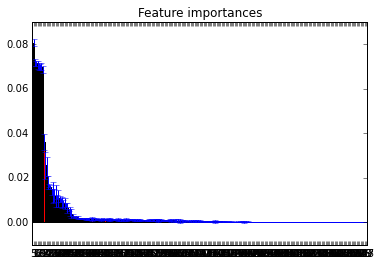

Feature ranking:
		Feature	Importance	Header
  	  1.	  5	(0.080633)	ListPrice
  	  2.	  1	(0.071589)	LivingArea
  	  3.	  0	(0.071269)	ListingId
  	  4.	  6	(0.070727)	GeoLat
  	  5.	  7	(0.069894)	GeoLon
  	  6.	  10	(0.069770)	TimeToClose
  	  7.	  8	(0.069749)	CloseDateInt
  	  8.	  9	(0.068521)	ListDateInt
  	  9.	  3	(0.035920)	NumBaths
  	  10.	  2	(0.025640)	NumBedrooms
  	  11.	  231	(0.025078)	patio
  	  12.	  4	(0.017978)	ExteriorStories
  	  13.	  241	(0.016529)	walk in closet
  	  14.	  235	(0.015931)	car garage
  	  15.	  236	(0.013790)	bedroom bath
  	  16.	  11	(0.013620)	PoolOrd
  	  17.	  233	(0.012083)	fans
  	  18.	  234	(0.011952)	covered patio
  	  19.	  237	(0.011333)	breakfast bar
  	  20.	  232	(0.010781)	fireplace
  	  21.	  242	(0.010374)	move in ready
  	  22.	  255	(0.010249)	trees
  	  23.	  12	(0.008809)	DwellingTypeOrd
  	  24.	  240	(0.008556)	ceiling fans
  	  25.	  238	(0.008527)	spa
  	  26.	  251	(0.007959)	granite counter
  	  27.	  243	(0.006342)	s

0

In [120]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,  # 250 by default
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")
print("\t\tFeature\tImportance\tHeader")

for f in range(X.shape[1]):
    print("  \t  %d.\t  %d\t(%f)\t%s" % (f+1, indices[f], importances[indices[f]], headers[indices[f]]))

os.system("say 'Computation Complete!'")    

In [101]:
## Wait Until Feature Reduction Calculation completes!!!
## Study showed re-running randomForest model reduced accuracy

## Drop features and see how mean-squared-error responds 
cutoff = 0.001  # Importance, 0.016 = remove
cols = []
cols = [i for i in indices if importances[i] < cutoff]
if len(cols) == 0:
    pass
else: X = X.drop(X.columns[cols],axis=1)
headers = X.dtypes.index
print(cols)
cols = []

[128, 109, 121, 131, 101, 126, 104, 49, 117, 43, 53, 33, 18, 108, 79, 105, 160, 76, 69, 58, 34, 61, 137, 107, 171, 83, 16, 54, 71, 125, 127, 65, 150, 68, 147, 103, 136, 163, 17, 57, 56, 42, 41, 162, 134, 50, 20, 151, 13, 67, 123, 153, 52, 47, 129, 112, 110, 25, 63, 208, 165, 36, 38, 148, 40, 191, 45, 14, 206, 199, 75, 139, 59, 194, 27, 149, 15, 158, 172, 205, 186, 204, 196, 62, 19, 193, 74, 135, 111, 64, 73, 189, 169, 211, 144, 197, 190, 90, 209, 214, 188, 95, 138, 202, 39, 198, 200, 175, 217, 152, 213, 210, 216, 174, 221, 222, 133, 66, 220, 96, 60, 212, 89, 219, 215, 173, 140, 207, 180, 203, 181, 179, 170, 195, 227, 94, 177, 226, 223, 176, 225, 201, 146, 132, 184, 178, 185, 218, 187, 154, 228, 224, 230, 182, 183, 72, 229, 192, 233]


In [ ]:
## Repeat Feature Reduction? If not, continue. 

In [ ]:
## Debug
#headers
#X.head(1)

<a id='section7'></a>
## Regression Model: Random Forest

In [102]:
## Random Forest
start_time = time.time()

model = RandomForestRegressor(n_estimators=50,  # ~n-attributes
                            max_features=None,
                            criterion='mse',
                            bootstrap=True,  # 'with replacement'
                            oob_score=True,
                            n_jobs=-1,       # Run on all available cores
                            random_state=0)

model.fit(X,y)

stop_time = time.time()
print("Regressor ran in %.2fs" % (stop_time - start_time))

os.system("say 'Computation Complete!'")    

## Attributes of RandomForest
# OOB Score (Out-Of-Bag Score)
#print('oob_score:', model.oob_score_)

Regressor ran in 26.55s


0

In [103]:
# Mean Squared Error
mse = sum((y-model.oob_prediction_)**2)/len(y)
print('Mean Squared Error (mse) = %3.6f' % mse)

# CV(RMSD), coefficient of variation
cvrmsd = math.sqrt(mse)/np.mean(y)
print('Coefficient of Variation, CV(RMSD) = %3.6f' % cvrmsd)

Mean Squared Error (mse) = 750933658.096873
Coefficient of Variation, CV(RMSD) = 0.113876


<a id='section8'></a>
## Regression Performance
### Entire dataset for training, no need for train/test/validation

0.997755968809 -- All Features  
0.997678529408 -- No Dummies  
0.997587756988 -- No hot-encoding  


//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


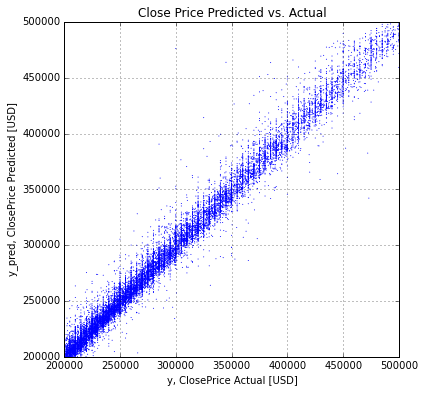

In [104]:
## Plot Resulting Prediction vs. Test(Actual)
## Isn't necessary for Random Forests, save for test/train data challenges.

plt.figure(figsize=(6,6))

plt.scatter(y, model.oob_prediction_, color='blue', s=1, edgecolor='none')
plt.xlim(200000,500000)
plt.ylim(200000,500000)
plt.grid(True)
plt.ylabel('y_pred, ClosePrice Predicted [USD]')
plt.xlabel('y, ClosePrice Actual [USD]')
plt.title('Close Price Predicted vs. Actual')
plt.axes().set_aspect('equal') # 'datalim'
plt.show()

In [ ]:
## Error Measurement: Variance between Prediction and Actual ClosePrice
## Isn't necessary for Random Forests, save for other algos.
#mean_squared_error(y_test, y_pred)

In [ ]:
## Debug Tools
#df.head(3)
#df['DwellingType'].head(20)
#df.describe()
#df.dtypes
#df.shape  #[1]
#df['LivingArea'] = df['LivingArea'].astype('float32')
#X.head(1)

In [ ]:
## Evaluate PCA to Determine Pricipal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1])  # Number of compenent vectors in the training set
pca.fit(X)
PCA(copy=True, n_components=25, whiten=False)
#print(pca.explained_variance_ratio_) 
# Note: first two contain 98% of the variance

In [ ]:
## Plot the PCA spectrum
plt.figure(figsize=(6, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2) # pca.explained_variance_
plt.axis('tight')
plt.grid(True)
plt.title('Scree Plot')
plt.xlabel('Principal Components [n]')
plt.ylabel('Percentage of Variance [%]') # for each eigenvector

<a id='section9'></a>
## What is Next?

After model is finalized, train on whole dataset. This isn't necessary with random forestunless a test set was created to compare to other machine learning algorithms.

Next, try GBM (Gradient Boosted Machines) and GLM (Generalized Linear Model). GBM Normally beats deep learning and GLM (and random forest with optimization). Use Mean-squared-error to compare regression models.  
  
Apply a meta-learner specifically a GLM (nnps) to stack/ensemble the algorithms.

Review generalized Low-rank model (GLRM), many classification algorithms are derived from the GLRM based on it's configuration.

Study of 'PublicRemarks', n-gram collection and vectorization to account for additional variance in ClosePrice.


### Missing data:  
Source: http://artsci.wustl.edu/~gradconf/conf2015/Papers2015/1_3_Ho.pdf    
- Age of home, when was it built/refreshed?  
- % of neighbors with bachelors  
- % of neighbors with mastors/adv. degree  
- quality of neighborhood schools  
-/ fireplace  - can be found in the PublicRemarks  

### Requested features:
- early stopping k-fold cross-validation